In [1]:
import os
import numpy as np
import statsmodels.api as sm
import pandas as pd
from collections import Counter

In [95]:
from sklearn.metrics import mean_squared_log_error

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [176]:
STATS_DIR = "/hg191/corpora/legaldata/data/stats/"
COURTS_CATEGORIES_FILE = "/hg191/corpora/legaldata/data/court.categories"
CURRENT_YEAR = 2018
NOBS = 50000
TRAIN_OBS_RANGE = (0,int(0.95*NOBS))
TEST_OBS_RANGE = (int(0.95*NOBS),NOBS)

In [4]:
with open (os.path.join (STATS_DIR, "ops.list")) as fin:
    ids = [(i, int(line.strip())) for i,line in enumerate (fin)]

In [177]:
# initialize a seed for repeatability
np.random.seed(100)
indices = np.random.choice(len(ids), NOBS, replace=False)

In [6]:
outd = pd.read_csv (os.path.join (STATS_DIR, "ops.outd"), sep=",", header=None, names=["id", "outd"])
ind = pd.read_csv (os.path.join (STATS_DIR, "ops.ind"), sep=",", header=None, names=["id", "ind"])
dates = pd.read_csv (os.path.join (STATS_DIR, "ops.dates"), sep=",", header=None, names=["id", "date"])
precedents = pd.read_csv (os.path.join (STATS_DIR, "ops.pubs"), sep=",", header=None, names=["id", "isPub"])
nPages = pd.read_csv (os.path.join (STATS_DIR, "ops.pages"), sep=",", header=None, names=["id", "npages"])
nUniqs = pd.read_csv (os.path.join (STATS_DIR, "ops.nuniqs"), sep=",", header=None, names=["id", "nuniqs"])
nTokens = pd.read_csv (os.path.join (STATS_DIR, "ops.ntokens"), sep=",", header=None, names=["id", "ntokens"])
courts = pd.read_csv (os.path.join (STATS_DIR, "ops.courts"), sep=",", header=None, names=["id", "courts"])
types = pd.read_csv (os.path.join (STATS_DIR, "ops.types"), sep=",", header=None, names=["id", "optype"])
semfeats = pd.read_csv (os.path.join (STATS_DIR, "ops.temp.semfeat"), sep=",", header=None, names=["id", "semfeat"])
bowfeats = pd.read_csv (os.path.join (STATS_DIR, "ops.temp.bowfeat"), sep=",", header=None, names=["id", "bowfeat"])

In [7]:
def df2dict (df, key, val):
    keys = df[key].values
    vals = df[val].values
    
    assert (len(keys) == len (vals))
    return {keys[i]: vals[i] for i in range (len(keys))}

In [8]:
O = df2dict (outd, "id", "outd")
I = df2dict (ind, "id", "ind")
D = df2dict (dates, "id", "date")
P = df2dict (precedents, "id", "isPub")
nP = df2dict (nPages, "id", "npages")
nU = df2dict (nUniqs, "id", "nuniqs")
nT = df2dict (nTokens, "id", "ntokens")
C = df2dict (courts, "id", "courts")
T = df2dict (types, "id", "optype")
S = df2dict (semfeats, "id", "semfeat")
B = df2dict (bowfeats, "id", "bowfeat")

**1. Dependent variable**

In [178]:
y = np.array ([I[ids[index][1]] for index in indices])
tr_y = y[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1]]
te_y = y[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

**2. Independent variables**

(a) Outdegree model

In [179]:
X_outd = np.array ([O[ids[index][1]] for index in indices])
X = sm.add_constant (X_outd)

In [180]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

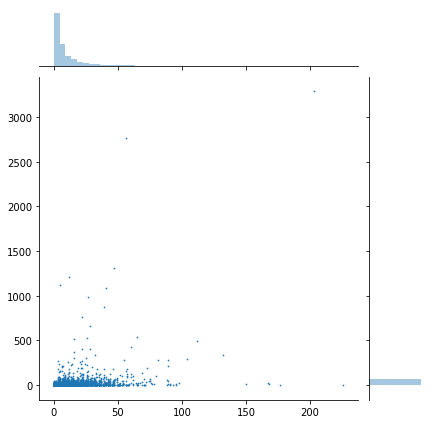

In [11]:
sns.jointplot(x=X_outd, y=y, kind='scatter', joint_kws={"s": 0.5})

In [181]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47498
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3293e+05
Date:                Wed, 28 Nov 2018   Deviance:                   1.2075e+05
Time:                        14:34:37   Pearson chi2:                 1.73e+06
No. Iterations:                    19   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0626      0.006    168.582      0.000       1.050       1.075
x1             0.0821      0.000    188.338      0.0

(b) +age

In [182]:
X_age = np.array ([CURRENT_YEAR - int(D[ids[index][1]].split("-")[0]) for index in indices])
X = np.array([X_outd, X_age]).T
X = sm.add_constant(X)

In [183]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [184]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47497
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2529e+05
Date:                Wed, 28 Nov 2018   Deviance:                   1.0548e+05
Time:                        14:35:03   Pearson chi2:                 1.19e+06
No. Iterations:                    26   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1140      0.010    -11.995      0.000      -0.133      -0.095
x1             0.1025      0.000    227.960      0.0

(c) + Age^2

In [188]:
X_age2 = np.array ([(CURRENT_YEAR - int(D[ids[index][1]].split("-")[0])) ** 2 for index in indices])
X = np.array([X_outd, X_age, X_age2]).T
X = sm.add_constant(X)

In [189]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [190]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47496
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2119e+05
Date:                Wed, 28 Nov 2018   Deviance:                       97271.
Time:                        14:36:37   Pearson chi2:                 9.66e+05
No. Iterations:                    57   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8465      0.013    -65.594      0.000      -0.872      -0.821
x1             0.1017      0.000    223.082      0.0

(d) Is a precedent

In [191]:
X_prec, prec_featnames = sm.tools.categorical(np.array([P[ids[index][1]] if P[ids[index][1]]=="Published" else "UnPublished" for index in indices]), dictnames=True, drop=True)
X = np.array([X_outd, X_age, X_age2]).T
X = np.hstack ((X, X_prec))
X = sm.add_constant(X)

In [192]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [193]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47495
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1414e+05
Date:                Wed, 28 Nov 2018   Deviance:                       83181.
Time:                        14:37:02   Pearson chi2:                 7.79e+05
No. Iterations:                    62   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0075      0.149    -20.137      0.000      -3.300      -2.715
x1             0.0907      0.000    195.182      0.0

(e) number of pages (ntypes + ntokens)

In [194]:
X_nuniqs = np.array ([nU[ids[index][1]] for index in indices])
X_nuniqs = X_nuniqs.reshape(len(indices), 1)
X = np.array([X_outd, X_age, X_age2]).T
X = np.hstack ((X, X_prec, X_nuniqs))
X = sm.add_constant(X)

In [195]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [196]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47494
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1234e+05
Date:                Wed, 28 Nov 2018   Deviance:                       79571.
Time:                        14:37:24   Pearson chi2:                 8.78e+05
No. Iterations:                    53   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3045      0.149    -22.115      0.000      -3.597      -3.012
x1             0.0416      0.001     54.809      0.0

(f) courts

In [197]:
court_cats = dict ()
with open (COURTS_CATEGORIES_FILE) as fin:
    for line in fin:
        parts = line.strip().split()
        court_cats[parts[0]] = parts[1]

In [198]:
def get_court_prefix (category):
    if category.startswith ("F"):
        return "F"
    elif category.startswith ("S"):
        return "S"
    else:
        return "O"

In [199]:
court_prefixes = [get_court_prefix(court_cats[C[ids[index][1]]]) for index in indices]
X_courts, court_features = sm.tools.categorical (np.array(court_prefixes), dictnames=True, drop=True)
X = np.array([X_outd, X_age, X_age2]).T
X = np.hstack ((X, X_prec, X_nuniqs, X_courts))
X = sm.add_constant(X)

In [200]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [201]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47492
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1187e+05
Date:                Wed, 28 Nov 2018   Deviance:                       78639.
Time:                        14:38:14   Pearson chi2:                 6.53e+05
No. Iterations:                   100   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6527      0.134    -19.828      0.000      -2.915      -2.390
x1             0.0406      0.001     53.234      0.0

(g) opinion type

In [202]:
X_types, type_features = sm.tools.categorical (np.array([T[ids[index][1]] for index in indices]), dictnames=True, drop=True)
X = np.array([X_outd, X_age, X_age2]).T
X = np.hstack ((X, X_prec, X_nuniqs, X_courts, X_types))
X = sm.add_constant(X)

In [288]:
type_features

{0: '010combined',
 1: '020lead',
 2: '030concurrence',
 3: '040dissent',
 4: '050addendum'}

In [203]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [204]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit()
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47488
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1047e+05
Date:                Wed, 28 Nov 2018   Deviance:                       75834.
Time:                        14:38:30   Pearson chi2:                 4.86e+05
No. Iterations:                    38   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0109      0.123    -24.484      0.000      -3.252      -2.770
x1             0.0364      0.001     47.561      0.0

(h) bow features

In [249]:
X_bowfeat = np.array ([B[ids[index][1]] for index in indices])
X_bowfeat = X_bowfeat.reshape(len(indices), 1)
X = np.array([X_outd, X_age, X_age2]).T
X = np.hstack ((X, X_prec, X_nuniqs, X_courts, X_types, X_bowfeat))
X = sm.add_constant(X)

In [250]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [256]:
results = sm.GLM(tr_y,trX,family=sm.families.NegativeBinomial()).fit(maxiter=300)
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47486
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0954e+05
Date:                Wed, 28 Nov 2018   Deviance:                   1.1568e+06
Time:                        15:00:10   Pearson chi2:                 5.14e+05
No. Iterations:                   300   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8659      0.123    -23.341      0.000      -3.107      -2.625
x1             0.0333      0.001     43.138      0.0

(i) semantic features

In [290]:
X_semfeat = np.array ([min(5, S[ids[index][1]]) for index in indices])
#X_semfeat[np.argmax(X_semfeat)] = 0
#X_semfeat[np.argsort(-X_semfeat)[1]] = 0
X_semfeat = (X_semfeat - np.mean(X_semfeat))/ np.std(X_semfeat)
X_semfeat = X_semfeat.reshape(len(indices), 1)
X = np.array([X_outd, X_age, X_age2]).T
X = np.hstack ((X, X_prec, X_nuniqs, X_courts, X_types, X_bowfeat, X_semfeat))
X = sm.add_constant(X)

In [291]:
trX = X[TRAIN_OBS_RANGE[0]:TRAIN_OBS_RANGE[1],:]
teX = X[TEST_OBS_RANGE[0]:TEST_OBS_RANGE[1]]

In [292]:
results = sm.GLM(tr_y,trX,family=sm.families.Poisson()).fit(maxiter=500)
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                47500
Model:                            GLM   Df Residuals:                    47486
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7823e+05
Date:                Wed, 28 Nov 2018   Deviance:                   8.6516e+05
Time:                        15:29:10   Pearson chi2:                 4.23e+06
No. Iterations:                    13   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4227      0.113    -21.528      0.000      -2.643      -2.202
x1             0.0135   9.44e-05    142.904      0.0

In [294]:
def estimate_overdispersion (orig_x, orig_y):
    "Calculates response observation for Cameron-Trivedi dispersion test"
    def ct_response (xx, yy):
        return np.array([((yy[i] - xx[i])**2 - yy[i]) / xx[i] for i in range (len (xx))])
    ct_results = sm.OLS (ct_response(orig_x, orig_y), orig_x).fit()
    alpha_ci95 = ct_results.conf_int(0.05)
    print('\nC-T dispersion test: alpha = {:5.3f}, 95% CI = ({:5.3f}, {:5.3f})'
        .format(ct_results.params[0], alpha_ci95[0,0], alpha_ci95[0,1]))
    return ct_results.params[0]
overdispersion = estimate_overdispersion (results.mu, tr_y)


C-T dispersion test: alpha = 1.875, 95% CI = (0.302, 3.448)


In [ ]:
results = sm.GLM(tr_y,trX,family=sm.families.Poisson()).fit(maxiter=500)
print(results.summary())
print("MSLE: {0}".format (mean_squared_log_error(te_y, results.predict(teX))))